In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [3]:
import torch.optim as optim
from torch.utils import data

In [4]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, ActNorm2D, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

### Datasets

In [6]:
cifar_train = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

cifar_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

train_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=True, download=True, transform=cifar_train)
test_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=False, download=True, transform=cifar_test)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# cifar_train = transforms.Compose([
#     transforms.RandomCrop(size=32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.5071, 0.4865, 0.4409],
#         std=[0.2009, 0.1984, 0.2023],
#     ),
# ])

# cifar_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.5071, 0.4865, 0.4409],
#         std=[0.2009, 0.1984, 0.2023],
#     ),
# ])

# train_dataset = datasets.CIFAR100(root="../../../../../_Datasets/cifar100/", train=True, download=True, transform=cifar_train)
# test_dataset = datasets.CIFAR100(root="../../../../../_Datasets/cifar100/", train=False, download=True, transform=cifar_test)

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [9]:
xx, yy = iter(train_loader).next()

In [10]:
xx.shape

torch.Size([128, 3, 32, 32])

### Model

In [11]:
actf = irf.Swish
flows = [
#     ActNorm2D(3),
    nn.BatchNorm2d(3),
    irf.ConvResidualFlow(3, [32, 32], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
#     ActNorm2D(12),
    nn.BatchNorm2d(12),
    irf.ConvResidualFlow(12, [64, 64], kernels=5, activation=actf),
#     ActNorm2D(12),
    nn.BatchNorm2d(12),
    irf.ConvResidualFlow(12, [64, 64], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
#     ActNorm2D(48),
    nn.BatchNorm2d(48),
    irf.ConvResidualFlow(48, [128, 128], kernels=5, activation=actf),
#     ActNorm2D(48),
    nn.BatchNorm2d(48),
    irf.ConvResidualFlow(48, [128, 128], kernels=5, activation=actf),
    irf.InvertiblePooling(2),
#     ActNorm2D(192),
    nn.BatchNorm2d(192),
    irf.ConvResidualFlow(192, [256, 256], kernels=5, activation=actf),
#     ActNorm2D(192),
    nn.BatchNorm2d(192),
    irf.ConvResidualFlow(192, [256, 256], kernels=5, activation=actf),
    nn.BatchNorm2d(192),
    irf.Flatten(img_size=(192, 4, 4)),
#     ActNorm(3072),
    nn.BatchNorm1d(3072),
    nn.Linear(3072, 2),
#     ActNorm(2),
    nn.BatchNorm1d(2),
        ]

# backbone = SequentialFlow(flows)
backbone = nn.Sequential(*flows)

In [12]:
backbone.to(device)

Sequential(
  (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ConvResidualFlow(
    (resblock): ModuleList(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): Swish()
      (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): Swish()
      (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (2): InvertiblePooling()
  (3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ConvResidualFlow(
    (resblock): ModuleList(
      (0): Conv2d(12, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): Swish()
      (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): Swish()
      (4): Conv2d(64, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ConvResidualFlow(
    (resblock)

In [13]:
def get_children(module):
    child = list(module.children())
    if len(child) == 0:
        return [module]
    children = []
    for ch in child:
        grand_ch = get_children(ch)
        children+=grand_ch
    return children

def remove_spectral_norm(model):
    for child in get_children(model):
        if hasattr(child, 'weight'):
            print("Yes", child)
            try:
                nn.utils.remove_spectral_norm(child)
                print("Success")
            except:
                print("Failed")
    return

In [14]:
# remove_spectral_norm(backbone)

In [15]:
backbone(xx.to(device)).shape, 32*32*3

(torch.Size([128, 2]), 3072)

In [16]:
print("number of params: ", sum(p.numel() for p in backbone.parameters()))

number of params:  9953669


In [17]:
for xx, yy in train_loader:
    tt = backbone(xx.to(device))
    print(xx.shape, tt.shape)
    break

torch.Size([128, 3, 32, 32]) torch.Size([128, 2])


In [18]:
class ConnectedClassifier_Linear(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.linear = nn.Linear(input_dim, num_sets)
#         self.linear.bias.data *= 0
#         self.linear.weight.data *= 0.1
#         self.cls_weight = nn.Parameter(torch.randn(num_sets, output_dim)/output_dim)

        init_val = torch.randn(num_sets, output_dim)
#         for ns in range(num_sets):
#             init_val[ns, ns%output_dim] = 5
        self.cls_weight = nn.Parameter(init_val)
        
        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
#         self.cls_weight.data = torch.abs(self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True))
        
        x = self.linear(x)
        x = x*torch.exp(self.inv_temp)

        if hard:
            x = torch.softmax(x*1e5, dim=1)
        else:
            x = torch.softmax(x, dim=1)
        self.cls_confidence = x
#         c = torch.softmax(self.cls_weight, dim=1)
        c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized

In [19]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
#         self.cls_weight = nn.Parameter(torch.ones(num_sets, output_dim)/output_dim)

        init_val = torch.randn(num_sets, output_dim)
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 5
        self.cls_weight = nn.Parameter(init_val)

        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
#         self.cls_weight.data = torch.abs(self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True))
        
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        dists = dists*torch.exp(self.inv_temp)

        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists, dim=1)
        self.cls_confidence = x
#         c = torch.softmax(self.cls_weight, dim=1)
        c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized
#         return torch.softmax(x@self.cls_weight, dim=1)

    def set_centroid_to_data_randomly(self, data_loader, model):
        num_centers = self.centers.shape[0]
        xxs, yys = [], []
        count = 0
        for xx, yy in data_loader:
            yout = model(xx.to(device)).data.cpu()
            xxs.append(yout)
            yys.append(yy)
            count += len(xx)
            if count >= num_centers:
                break
        
        yout = torch.cat(xxs, dim=0)
        yy = torch.cat(yys, dim=0)
        
        yout = yout[:num_centers].to(self.centers.device)
        yy = yy[:num_centers].to(self.centers.device)
        
        self.centers.data = yout
        
        init_val = torch.randn(self.num_sets, self.output_dim)
        for ns in range(num_centers):
            init_val[ns, yy[ns]] = 5
        self.cls_weight.data = init_val.to(self.cls_weight.device)
        pass

In [20]:
train_loader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../../../../../_Datasets/cifar10/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
           )

In [21]:
train_loader.dataset.transforms

StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
           )

In [23]:
#### C10
# classifier = ConnectedClassifier_SoftKMeans(2, 20, 10)
classifier = ConnectedClassifier_Linear(2, 20, 10, inv_temp=0)
#### C100
# classifier = ConnectedClassifier_SoftKMeans(2, 500, 100, inv_temp=0)
# classifier = ConnectedClassifier_Linear(2, 500, 100, inv_temp=0)
#### for MLP based classification
# classifier = nn.Sequential(nn.Linear(2, 500), nn.SELU(), nn.Linear(500, 100))

classifier = classifier.to(device)

In [24]:
# classifier.set_centroid_to_data_randomly(train_loader, backbone)

In [25]:
print("number of params: ", sum(p.numel() for p in backbone.parameters()))
print("number of params: ", sum(p.numel() for p in classifier.parameters()))

number of params:  9953669
number of params:  261


In [26]:
model = nn.Sequential(backbone, classifier).to(device)

In [27]:
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  9953930


## Training

In [29]:
# model_name = 'c100_2d_multi_inv_mlp_v0'
model_name = 'c10_2d_multi-lin_inv_v1' ## using unnormalized classifier output

In [30]:
# model_name = 'c10_2d_multi_inv_v0'
# model_name = 'c10_2d_multi_ord_v0'
# model_name = 'c100_2d_multi_inv_v0'
# model_name = 'c100_2d_multi_ord_v0'

In [31]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1,
#                       momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [32]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [33]:
best_acc = -1
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc

In [34]:
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
resume = False

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('./models'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(f'./models/{model_name}.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [35]:
### Train the whole damn thing

for epoch in range(start_epoch, start_epoch+200): ## for 200 epochs
    train(epoch)
    test(epoch)
    scheduler.step()

  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 0 Loss: 2.212 | Acc: 15.896 7948/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 0 Loss: 2.125 | Acc: 21.300 2130/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 1 Loss: 2.113 | Acc: 23.626 11813/50000


100%|██████████| 79/79 [00:02<00:00, 28.61it/s]


[Test] 1 Loss: 2.025 | Acc: 31.330 3133/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 2 Loss: 2.007 | Acc: 32.854 16427/50000


100%|██████████| 79/79 [00:02<00:00, 28.48it/s]


[Test] 2 Loss: 1.933 | Acc: 36.770 3677/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 3 Loss: 1.894 | Acc: 38.556 19278/50000


100%|██████████| 79/79 [00:02<00:00, 28.49it/s]


[Test] 3 Loss: 1.816 | Acc: 40.580 4058/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 4 Loss: 1.785 | Acc: 42.562 21281/50000


100%|██████████| 79/79 [00:02<00:00, 28.53it/s]


[Test] 4 Loss: 1.748 | Acc: 45.190 4519/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 5 Loss: 1.686 | Acc: 46.180 23090/50000


100%|██████████| 79/79 [00:02<00:00, 28.49it/s]


[Test] 5 Loss: 1.631 | Acc: 48.780 4878/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 6 Loss: 1.592 | Acc: 48.774 24387/50000


100%|██████████| 79/79 [00:02<00:00, 28.48it/s]


[Test] 6 Loss: 1.542 | Acc: 49.660 4966/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 7 Loss: 1.508 | Acc: 50.358 25179/50000


100%|██████████| 79/79 [00:02<00:00, 28.45it/s]


[Test] 7 Loss: 1.496 | Acc: 50.500 5050/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 8 Loss: 1.439 | Acc: 51.460 25730/50000


100%|██████████| 79/79 [00:02<00:00, 28.47it/s]


[Test] 8 Loss: 1.399 | Acc: 52.200 5220/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 9 Loss: 1.375 | Acc: 52.942 26471/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 9 Loss: 1.400 | Acc: 50.840 5084/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 10 Loss: 1.327 | Acc: 53.798 26899/50000


100%|██████████| 79/79 [00:02<00:00, 28.44it/s]


[Test] 10 Loss: 1.333 | Acc: 53.910 5391/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 11 Loss: 1.275 | Acc: 55.430 27715/50000


100%|██████████| 79/79 [00:02<00:00, 28.50it/s]


[Test] 11 Loss: 1.289 | Acc: 55.810 5581/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 12 Loss: 1.232 | Acc: 57.574 28787/50000


100%|██████████| 79/79 [00:02<00:00, 28.47it/s]


[Test] 12 Loss: 1.252 | Acc: 58.580 5858/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 13 Loss: 1.190 | Acc: 60.382 30191/50000


100%|██████████| 79/79 [00:02<00:00, 28.51it/s]


[Test] 13 Loss: 1.225 | Acc: 59.400 5940/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 14 Loss: 1.148 | Acc: 62.642 31321/50000


100%|██████████| 79/79 [00:02<00:00, 28.42it/s]


[Test] 14 Loss: 1.173 | Acc: 61.920 6192/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 15 Loss: 1.106 | Acc: 64.278 32139/50000


100%|██████████| 79/79 [00:02<00:00, 28.48it/s]


[Test] 15 Loss: 1.172 | Acc: 63.170 6317/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 16 Loss: 1.069 | Acc: 65.788 32894/50000


100%|██████████| 79/79 [00:02<00:00, 28.45it/s]


[Test] 16 Loss: 1.115 | Acc: 65.640 6564/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 17 Loss: 1.033 | Acc: 67.546 33773/50000


100%|██████████| 79/79 [00:02<00:00, 28.48it/s]


[Test] 17 Loss: 1.086 | Acc: 67.090 6709/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 18 Loss: 0.994 | Acc: 69.668 34834/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 18 Loss: 1.082 | Acc: 66.930 6693/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 19 Loss: 0.955 | Acc: 71.778 35889/50000


100%|██████████| 79/79 [00:02<00:00, 28.47it/s]


[Test] 19 Loss: 1.006 | Acc: 70.900 7090/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 20 Loss: 0.915 | Acc: 74.092 37046/50000


100%|██████████| 79/79 [00:02<00:00, 28.48it/s]


[Test] 20 Loss: 0.980 | Acc: 73.720 7372/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 21 Loss: 0.878 | Acc: 75.712 37856/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 21 Loss: 0.957 | Acc: 72.860 7286/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 22 Loss: 0.843 | Acc: 77.422 38711/50000


100%|██████████| 79/79 [00:02<00:00, 28.45it/s]


[Test] 22 Loss: 0.936 | Acc: 74.980 7498/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 23 Loss: 0.817 | Acc: 78.444 39222/50000


100%|██████████| 79/79 [00:02<00:00, 28.46it/s]


[Test] 23 Loss: 0.925 | Acc: 75.110 7511/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 24 Loss: 0.788 | Acc: 79.788 39894/50000


100%|██████████| 79/79 [00:02<00:00, 28.50it/s]


[Test] 24 Loss: 0.916 | Acc: 76.490 7649/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 25 Loss: 0.757 | Acc: 80.846 40423/50000


100%|██████████| 79/79 [00:02<00:00, 28.44it/s]


[Test] 25 Loss: 0.902 | Acc: 76.980 7698/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 26 Loss: 0.732 | Acc: 81.658 40829/50000


100%|██████████| 79/79 [00:02<00:00, 28.43it/s]


[Test] 26 Loss: 0.850 | Acc: 78.060 7806/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 27 Loss: 0.703 | Acc: 82.340 41170/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 27 Loss: 0.880 | Acc: 77.030 7703/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 28 Loss: 0.686 | Acc: 82.488 41244/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 28 Loss: 0.829 | Acc: 77.860 7786/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 29 Loss: 0.664 | Acc: 82.858 41429/50000


100%|██████████| 79/79 [00:02<00:00, 28.43it/s]


[Test] 29 Loss: 0.836 | Acc: 78.070 7807/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 30 Loss: 0.652 | Acc: 83.090 41545/50000


100%|██████████| 79/79 [00:02<00:00, 28.42it/s]


[Test] 30 Loss: 0.839 | Acc: 78.110 7811/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 31 Loss: 0.628 | Acc: 83.610 41805/50000


100%|██████████| 79/79 [00:02<00:00, 28.42it/s]


[Test] 31 Loss: 0.801 | Acc: 79.150 7915/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 32 Loss: 0.625 | Acc: 83.574 41787/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 32 Loss: 0.800 | Acc: 78.480 7848/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 33 Loss: 0.605 | Acc: 83.980 41990/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 33 Loss: 0.811 | Acc: 78.610 7861/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 34 Loss: 0.592 | Acc: 84.390 42195/50000


100%|██████████| 79/79 [00:02<00:00, 28.38it/s]


[Test] 34 Loss: 0.775 | Acc: 79.370 7937/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 35 Loss: 0.584 | Acc: 84.558 42279/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 35 Loss: 0.812 | Acc: 78.300 7830/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 36 Loss: 0.576 | Acc: 84.770 42385/50000


100%|██████████| 79/79 [00:02<00:00, 28.42it/s]


[Test] 36 Loss: 0.750 | Acc: 79.890 7989/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 37 Loss: 0.560 | Acc: 85.134 42567/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 37 Loss: 0.769 | Acc: 79.470 7947/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 38 Loss: 0.555 | Acc: 85.342 42671/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 38 Loss: 0.779 | Acc: 79.010 7901/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 39 Loss: 0.553 | Acc: 85.188 42594/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 39 Loss: 0.745 | Acc: 79.780 7978/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 40 Loss: 0.539 | Acc: 85.740 42870/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 40 Loss: 0.789 | Acc: 78.960 7896/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 41 Loss: 0.527 | Acc: 86.150 43075/50000


100%|██████████| 79/79 [00:02<00:00, 28.43it/s]


[Test] 41 Loss: 0.758 | Acc: 80.220 8022/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 42 Loss: 0.513 | Acc: 86.392 43196/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 42 Loss: 0.761 | Acc: 79.880 7988/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 43 Loss: 0.517 | Acc: 86.278 43139/50000


100%|██████████| 79/79 [00:02<00:00, 28.42it/s]


[Test] 43 Loss: 0.745 | Acc: 80.340 8034/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 44 Loss: 0.501 | Acc: 86.724 43362/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 44 Loss: 0.733 | Acc: 80.120 8012/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 45 Loss: 0.507 | Acc: 86.498 43249/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 45 Loss: 0.738 | Acc: 80.290 8029/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 46 Loss: 0.498 | Acc: 86.820 43410/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 46 Loss: 0.765 | Acc: 79.410 7941/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 47 Loss: 0.481 | Acc: 87.104 43552/50000


100%|██████████| 79/79 [00:02<00:00, 28.45it/s]


[Test] 47 Loss: 0.738 | Acc: 80.670 8067/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 48 Loss: 0.479 | Acc: 87.300 43650/50000


100%|██████████| 79/79 [00:02<00:00, 28.43it/s]


[Test] 48 Loss: 0.710 | Acc: 81.170 8117/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 49 Loss: 0.472 | Acc: 87.566 43783/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 49 Loss: 0.753 | Acc: 80.110 8011/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 50 Loss: 0.469 | Acc: 87.680 43840/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 50 Loss: 0.722 | Acc: 81.100 8110/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 51 Loss: 0.466 | Acc: 87.844 43922/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 51 Loss: 0.724 | Acc: 80.450 8045/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 52 Loss: 0.445 | Acc: 88.316 44158/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 52 Loss: 0.749 | Acc: 80.340 8034/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 53 Loss: 0.441 | Acc: 88.304 44152/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 53 Loss: 0.741 | Acc: 80.140 8014/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 54 Loss: 0.454 | Acc: 88.042 44021/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 54 Loss: 0.754 | Acc: 79.730 7973/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 55 Loss: 0.439 | Acc: 88.462 44231/50000


100%|██████████| 79/79 [00:02<00:00, 28.42it/s]


[Test] 55 Loss: 0.697 | Acc: 81.570 8157/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 56 Loss: 0.425 | Acc: 88.878 44439/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 56 Loss: 0.708 | Acc: 81.320 8132/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 57 Loss: 0.431 | Acc: 88.702 44351/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 57 Loss: 0.739 | Acc: 80.860 8086/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 58 Loss: 0.426 | Acc: 88.650 44325/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 58 Loss: 0.732 | Acc: 80.980 8098/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 59 Loss: 0.421 | Acc: 88.846 44423/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 59 Loss: 0.703 | Acc: 81.290 8129/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 60 Loss: 0.409 | Acc: 89.322 44661/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 60 Loss: 0.711 | Acc: 81.370 8137/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 61 Loss: 0.405 | Acc: 89.318 44659/50000


100%|██████████| 79/79 [00:02<00:00, 28.42it/s]


[Test] 61 Loss: 0.691 | Acc: 81.870 8187/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 62 Loss: 0.392 | Acc: 89.622 44811/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 62 Loss: 0.691 | Acc: 81.430 8143/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 63 Loss: 0.407 | Acc: 89.048 44524/50000


100%|██████████| 79/79 [00:02<00:00, 28.34it/s]


[Test] 63 Loss: 0.677 | Acc: 82.030 8203/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 64 Loss: 0.388 | Acc: 89.746 44873/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 64 Loss: 0.713 | Acc: 81.530 8153/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 65 Loss: 0.400 | Acc: 89.236 44618/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 65 Loss: 0.726 | Acc: 80.160 8016/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 66 Loss: 0.389 | Acc: 89.714 44857/50000


100%|██████████| 79/79 [00:02<00:00, 28.38it/s]


[Test] 66 Loss: 0.683 | Acc: 82.290 8229/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 67 Loss: 0.384 | Acc: 89.676 44838/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 67 Loss: 0.672 | Acc: 82.210 8221/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 68 Loss: 0.371 | Acc: 90.054 45027/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 68 Loss: 0.679 | Acc: 82.010 8201/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 69 Loss: 0.387 | Acc: 89.574 44787/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 69 Loss: 0.729 | Acc: 80.390 8039/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 70 Loss: 0.376 | Acc: 89.916 44958/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 70 Loss: 0.688 | Acc: 81.040 8104/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 71 Loss: 0.364 | Acc: 90.170 45085/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 71 Loss: 0.712 | Acc: 80.600 8060/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 72 Loss: 0.400 | Acc: 88.948 44474/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 72 Loss: 0.696 | Acc: 81.870 8187/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 73 Loss: 0.354 | Acc: 90.540 45270/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 73 Loss: 0.686 | Acc: 81.980 8198/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 74 Loss: 0.351 | Acc: 90.650 45325/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 74 Loss: 0.683 | Acc: 82.140 8214/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 75 Loss: 0.340 | Acc: 90.962 45481/50000


100%|██████████| 79/79 [00:02<00:00, 28.43it/s]


[Test] 75 Loss: 0.670 | Acc: 82.580 8258/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 76 Loss: 0.331 | Acc: 91.346 45673/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 76 Loss: 0.683 | Acc: 82.050 8205/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 77 Loss: 0.339 | Acc: 90.938 45469/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 77 Loss: 0.669 | Acc: 82.520 8252/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 78 Loss: 0.332 | Acc: 91.064 45532/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 78 Loss: 0.697 | Acc: 81.810 8181/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 79 Loss: 0.331 | Acc: 91.342 45671/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 79 Loss: 0.681 | Acc: 82.060 8206/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 80 Loss: 0.317 | Acc: 91.630 45815/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 80 Loss: 0.678 | Acc: 82.300 8230/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 81 Loss: 0.326 | Acc: 91.402 45701/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 81 Loss: 0.690 | Acc: 82.010 8201/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 82 Loss: 0.317 | Acc: 91.564 45782/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 82 Loss: 0.684 | Acc: 82.290 8229/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 83 Loss: 0.304 | Acc: 92.036 46018/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 83 Loss: 0.676 | Acc: 82.460 8246/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 84 Loss: 0.303 | Acc: 92.024 46012/50000


100%|██████████| 79/79 [00:02<00:00, 28.39it/s]


[Test] 84 Loss: 0.667 | Acc: 82.660 8266/10000
Saving..


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 85 Loss: 0.306 | Acc: 91.900 45950/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 85 Loss: 0.681 | Acc: 82.270 8227/10000


  0%|          | 0/79 [00:00<?, ?it/s]

[Train] 86 Loss: 0.292 | Acc: 92.454 46227/50000


  0%|          | 0/391 [00:00<?, ?it/s]

[Test] 86 Loss: 0.684 | Acc: 82.630 8263/10000


 63%|██████▎   | 247/391 [00:25<00:14,  9.68it/s]


KeyboardInterrupt: 

In [36]:
best_acc

82.66

In [37]:
######## C100
#### inv nn with MLP classifier: 31.58 Acc ;
#### non-inv nn with MLP classifier: 11.89 Acc ;
#### inv nn with Distance classifier: 26.89 Acc ;

In [38]:
classifier.inv_temp

Parameter containing:
tensor([1.5093], device='cuda:0', requires_grad=True)

In [39]:
checkpoint = torch.load(f'./models/{model_name}.pth')
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

best_acc, start_epoch

(82.66, 84)

In [40]:
checkpoint.keys()

dict_keys(['model', 'acc', 'epoch'])

In [41]:
model_name

'c10_2d_multi-lin_inv_v1'

In [39]:
asdasd

NameError: name 'asdasd' is not defined

In [42]:
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

### Hard test accuracy with count per classifier

In [43]:
model.eval()
print("Testing")

Testing


In [44]:
backbone, classifier = model[0], model[1]

In [45]:
classifier

ConnectedClassifier_Linear(
  (linear): Linear(in_features=2, out_features=20, bias=True)
)

In [46]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(test_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(backbone(xx), hard=True)
        set_indx, count = torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True) 
        set_count[set_indx] += count
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
    test_acc += correct
    test_count += len(xx)

print(f'Hard Test Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

100%|██████████| 79/79 [00:02<00:00, 28.25it/s]

Hard Test Acc:82.37%
[1016, 976, 931, 922, 0, 1134, 945, 790, 985, 311, 0, 0, 0, 0, 1129, 0, 0, 190, 0, 671]


In [47]:
#### Classifiers that enclose any data
torch.count_nonzero(set_count)

tensor(12, device='cuda:0')

In [48]:
embeddings, labels, ilabels = [], [], []
model.eval()
for xx, yy in tqdm(test_loader):
    ilabels.append(yy)
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        embs = backbone(xx)
        embeddings.append(embs.cpu())
        
#         yout = classifier(embs, hard=True)
        yout = classifier(embs)
        labels.append(torch.argmax(yout, dim=1).cpu())

embeddings = torch.cat(embeddings, dim=0)
labels = torch.cat(labels, dim=0)
ilabels = torch.cat(ilabels, dim=0)

100%|██████████| 79/79 [00:02<00:00, 28.19it/s]


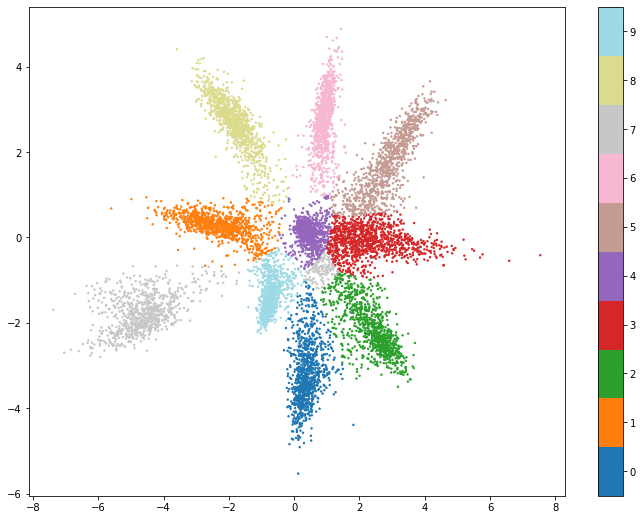

In [49]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=labels, s=2, cmap='tab20')

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

# plt.savefig('./output/01_prediction_c10.pdf')

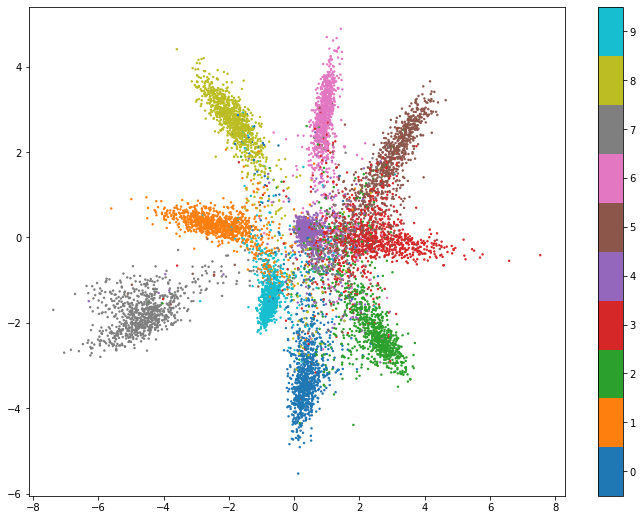

In [50]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

# plt.savefig('./output/02_ground_truth_c10.pdf')

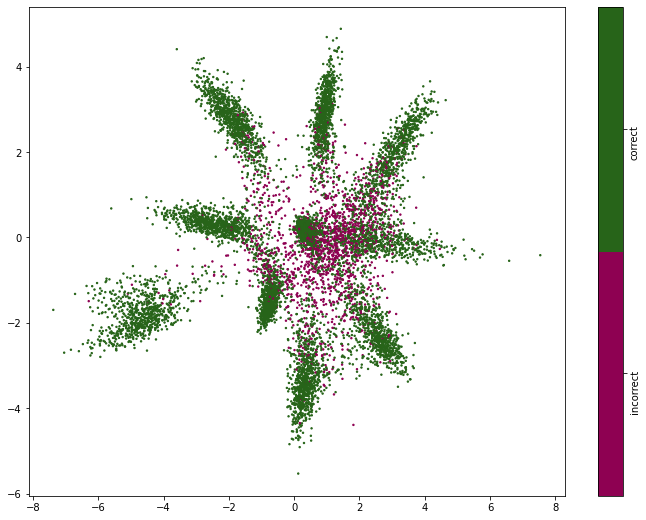

In [51]:
### Error Nodes
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=(labels==ilabels), s=2, cmap='PiYG')

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(3)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(['incorrect', 'correct', ])
cbar.ax.tick_params(rotation=90)

# plt.savefig('./output/03_errors_c10.pdf')

### plot on a 2D map, the decision boundary

In [52]:
ng = 1000
_a,_b,_c,_d = embeddings[:,0].min()-0.1, embeddings[:,0].max()+0.1, embeddings[:,1].min()-0.1, embeddings[:,1].max()+0.1
xg, yg = torch.linspace(_a, _b, ng), torch.linspace(_c, _d, ng)
xg, yg = torch.meshgrid(xg, yg)
xyg = torch.stack([xg.reshape(-1), yg.reshape(-1)], dim=-1)

In [53]:
BS = 1000
output = []
for i in range(0, len(xyg), BS):
    xx = xyg[i:i+BS].to(device)
    with torch.no_grad():
#         yout = classifier(xx, hard=True)
        yout = classifier(xx)
        output.append(torch.argmax(yout, dim=1).cpu())
        
output = torch.cat(output, dim=0)

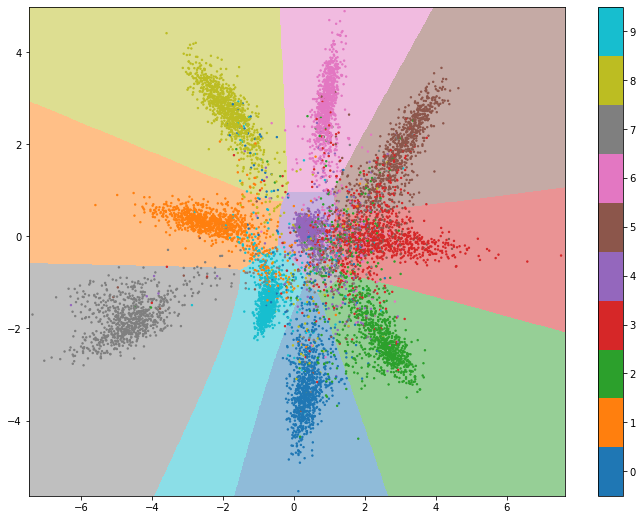

In [54]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

plt.imshow(output.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.5, cmap='tab10',
           aspect='auto', origin='lower')

# plt.savefig('./output/04_DecisionBoundary_Class_c10.pdf')

In [55]:
## display different class boundary
BS = 1000
output2 = []
for i in range(0, len(xyg), BS):
    xx = xyg[i:i+BS].to(device)
    with torch.no_grad():
        yout = classifier(xx, hard=True)
        output2.append(torch.argmax(classifier.cls_confidence, dim=1).cpu())
output2 = torch.cat(output2, dim=0)

(-5.6318440437316895, 4.985398769378662)

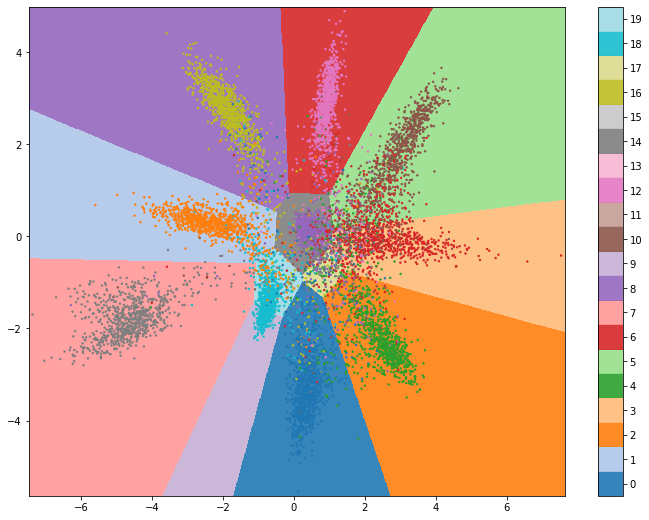

In [57]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')

plt.imshow(output2.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.9, cmap='tab20',
           aspect='auto', origin='lower')

cbar = plt.colorbar(ticks=range(20), #label='classes', 
                    boundaries=np.arange(21)-0.5)
cbar.set_ticks(np.arange(20))
cbar.set_ticklabels(list(range(20)))

### plot centroids as well
# plt.scatter(*classifier[1].centers.data.cpu().numpy().T, marker='*', c='k')
# plt.scatter(*classifier.centers.data.cpu().numpy().T, marker='*', c='k')

plt.xlim(xg.min(), xg.max())
plt.ylim(yg.min(), yg.max()) 
# plt.savefig('./output/05_DecisionBoundary_Sets_c10.pdf')

### Hard train accuracy with count per classifier

In [ ]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(train_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(backbone(xx), hard=True)
        set_indx, count = torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True) 
        set_count[set_indx] += count
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
    test_acc += correct
    test_count += len(xx)

print(f'Hard Train Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

In [ ]:
#### Classifiers that enclose any data
torch.count_nonzero(set_count)

In [ ]:
#### classifier with class representation
torch.argmax(classifier.cls_weight, dim=1)

### analyze per classifier accuracy

In [ ]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
set_acc = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(train_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(backbone(xx), hard=True)
        
    cls_indx = torch.argmax(classifier.cls_confidence, dim=1)
    set_indx, count = torch.unique(cls_indx, return_counts=True) 
    set_count[set_indx] += count
    
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float)
    
    ### class_index has 100 possible values
    for i, c in enumerate(correct):
        set_acc[cls_indx[i]] += c
    
#     print(set_acc.sum(), set_count.sum())
#     break
    test_acc += correct.sum()
    test_count += len(xx)

print(f'Hard Train Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

In [ ]:
# set_acc/set_count

In [ ]:
for i, (cnt, acc, cls) in enumerate(zip(set_count.type(torch.long).tolist(),
                                   (set_acc/set_count).tolist(),
                                   torch.argmax(classifier.cls_weight, dim=1).tolist())):
    if cnt == 0: continue
    print(f"{i},\t {cnt},\t {cls}\t {acc*100:.2f}%")